<a href="https://colab.research.google.com/github/juand4g/MetodosComputacionales2-G02/blob/main/T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [335]:
data = pd.read_csv('Rhodium.csv')
data

,Wavelength (pm),Intensity (mJy)
0,10.2419,0.0001
1,10.4837,0.0001
2,10.7256,0.0001
3,10.9675,0.0001
4,11.2093,0.0001
...,...,...
1194,299.0325,0.0036
1195,299.2744,0.0248
1196,299.5163,0.0035
1197,299.7581,0.0037


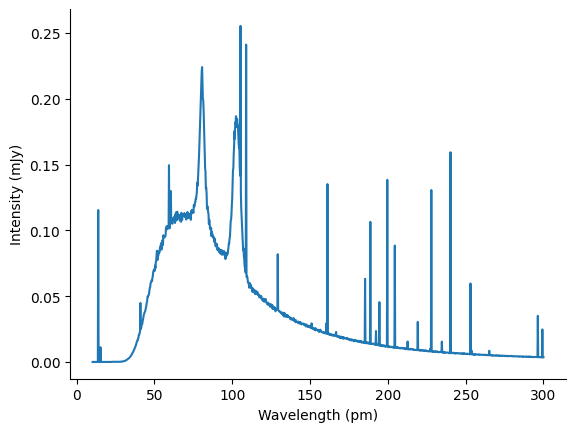

In [336]:
graph1 = plt.plot(data["Wavelength (pm)"], data['Intensity (mJy)'], label="Intensity (mJy)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Wavelength (pm)")
plt.ylabel("Intensity (mJy)")
graph1

In [337]:
#Calcular promedio de diferencias entre datos consecutivos
prom_dx = 0
n = len(data["Intensity (mJy)"])
i = 0
while i < n-1:
  intensity = data["Intensity (mJy)"][i]
  intensity_next = data["Intensity (mJy)"][i+1]
  dx = abs(intensity - intensity_next)
  prom_dx += dx
  i += 1
prom_dx = prom_dx/n



In [338]:
#Limpieza inicial con tolerancia 4.4
cleaned_data = data.copy()
j = 0
n_eliminados = 0
tol = 4.4
while j < n-1:
  intensity = cleaned_data["Intensity (mJy)"][j]
  intensity_next = cleaned_data["Intensity (mJy)"][j+1]
  dx = abs(intensity - intensity_next)
  if dx > tol*prom_dx:
    cleaned_data["Intensity (mJy)"][j+1] = intensity
    n_eliminados += 1
  j+=1

C:\Users\Juan\AppData\Local\Temp\ipykernel_3908\1962753007.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cleaned_data["Intensity (mJy)"][j+1] = intensity


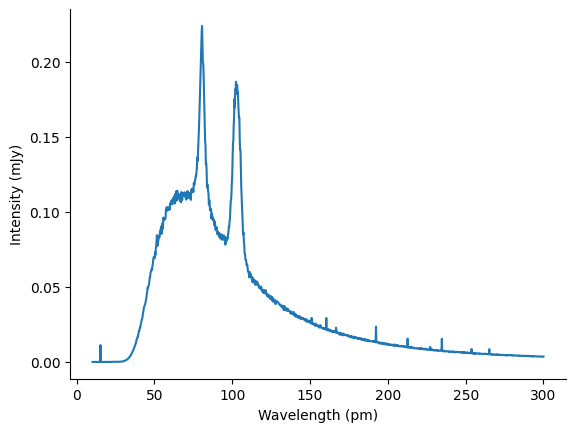

In [339]:
graph2 = plt.plot(cleaned_data["Wavelength (pm)"], cleaned_data['Intensity (mJy)'], label="Intensity (mJy)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Wavelength (pm)")
plt.ylabel("Intensity (mJy)")
graph2

In [340]:
#Limpieza secundaria focalizada en los datos corruptos restantes, en donde la pendiente es menos pronunciada, así que es necesario usar menos tolerancia
k = 0
tol2 = 1.0
while (not (100 < k < 500)) and (k < n-1):
  intensity = cleaned_data["Intensity (mJy)"][k]
  intensity_next = cleaned_data["Intensity (mJy)"][k+1]
  dx = abs(intensity - intensity_next)
  if dx > tol2*prom_dx:
    cleaned_data["Intensity (mJy)"][k+1] = intensity
    n_eliminados += 1
  k+=1
  if k == 100:
    k = 501

C:\Users\Juan\AppData\Local\Temp\ipykernel_3908\2937007065.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cleaned_data["Intensity (mJy)"][k+1] = intensity


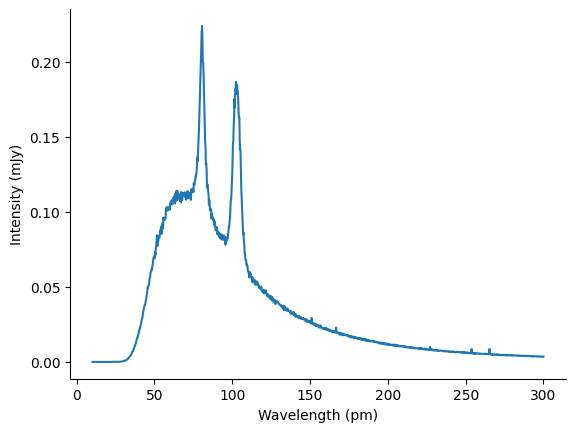

In [341]:
graph3 = plt.plot(cleaned_data["Wavelength (pm)"], cleaned_data['Intensity (mJy)'], label="Intensity (mJy)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Wavelength (pm)")
plt.ylabel("Intensity (mJy)")
graph3

In [342]:
print(f'1.a) Número de datos eliminados: {n_eliminados}')

1.a) Número de datos eliminados: 25


In [343]:
def rad_fondo(x, a, b, c, d, e):
  return   a * x**4 + b * x**3 + c * x**2 + d * x + e   #polinomial grado 4
  #return  a * np.exp(-b * x) + c #exponencial
  #return a * np.exp(-b*x) + c * x**2 + d * x + e #polinomial g2 + exponencial
  #return a * np.cos(b*x) + c*np.exp(-d*x) +e # seno + exponencial

In [344]:
indices_picos = range(260,420)

# Crear una máscara para excluir los picos
mascara = np.ones_like(cleaned_data['Wavelength (pm)'], dtype=bool)

# Crear la máscara excluyendo los picos
mascara = ~cleaned_data.index.isin(indices_picos)
mascara_picos = ~mascara

In [345]:
#Suavizado de los datos con máscara
fondo_suave = savgol_filter(cleaned_data['Intensity (mJy)'][mascara], window_length=51, polyorder=3)
fondo_suave

array([9.41742477e-05, 9.59576412e-05, 9.75181106e-05, ...,
       3.62599566e-03, 3.61928544e-03, 3.61305324e-03], shape=(1039,))

In [346]:
#popt, pcov = curve_fit(rad_fondo,cleaned_data['Wavelength (pm)'][mascara], cleaned_data['Intensity (mJy)'][mascara],p0=[100,0.3,0,1,2])

#Se estima la curva utilizando la muestra con máscara y suavizada
popt, pcov = curve_fit(rad_fondo,cleaned_data['Wavelength (pm)'][mascara], fondo_suave,p0=[100,0.3,0,1,2])
a,b,c,d,e=popt

In [347]:
cleaned_data["frenado"] = rad_fondo(cleaned_data['Wavelength (pm)'],a,b,c,d,e)
cleaned_data["residual"] = cleaned_data['Intensity (mJy)'] - cleaned_data["frenado"]

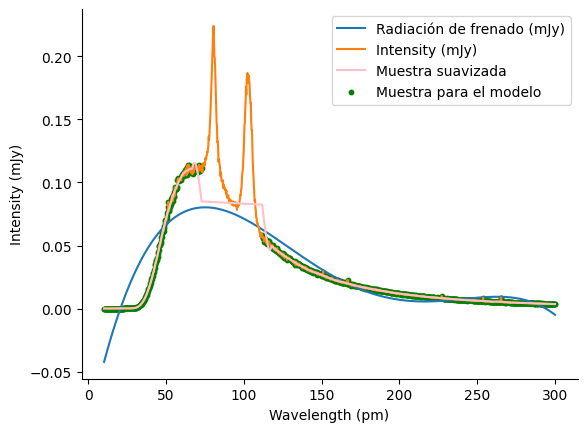

In [348]:
model_graph = plt.plot(cleaned_data["Wavelength (pm)"], cleaned_data["frenado"], label="Radiación de frenado (mJy)")
model_graph = plt.plot(cleaned_data["Wavelength (pm)"], cleaned_data['Intensity (mJy)'], label="Intensity (mJy)")
model_graph = plt.plot(cleaned_data["Wavelength (pm)"][mascara], fondo_suave, label="Muestra suavizada", color="pink")

plt.scatter(
    cleaned_data['Wavelength (pm)'][mascara],
    cleaned_data['Intensity (mJy)'][mascara],
    label="Muestra para el modelo",
    color="green",
    s=10,  # Tamaño de los puntos
)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Wavelength (pm)")
plt.ylabel("Intensity (mJy)")
plt.legend()  # Mostrar la leyenda
plt.show()

In [349]:
#Se actualizan las intensidades quitando la radiación de frenado
cleaned_data['Intensity (mJy)'] = cleaned_data["Intensity (mJy)"]-cleaned_data["frenado"]
#cleaned_data['Intensity (mJy)'] = cleaned_data["Intensity (mJy)"][mascara]-fondo_suave


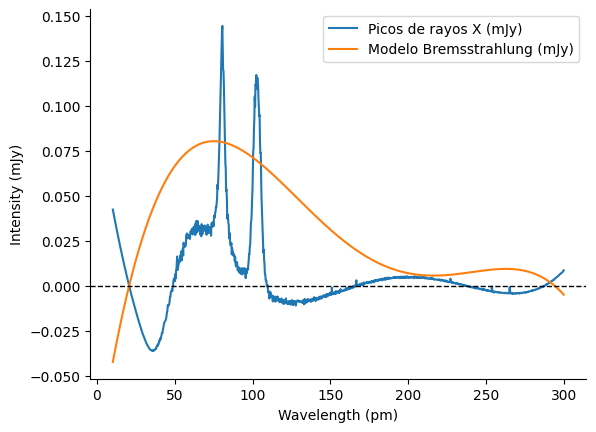

In [350]:
graph4 = plt.plot(cleaned_data["Wavelength (pm)"], cleaned_data['Intensity (mJy)'], label="Picos de rayos X (mJy)")
plt.plot(cleaned_data["Wavelength (pm)"], cleaned_data['frenado'], label="Modelo Bremsstrahlung (mJy)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Wavelength (pm)")
plt.ylabel("Intensity (mJy)")
plt.legend()
plt.savefig("picos.pdf", format="pdf")

graph4

In [351]:
print('1.b) Método: Ajuste de curva con Scipy.')

1.b) Método: Ajuste de curva con Scipy.
